## Description
Jane works in software. But the job is indoors, so, seeking more time outdoors, she became a part-time postwoman. It was exciting. She could visit different places every day in her town. Everyday she goes to post office. Collect all the letters, and then delivers them. But she is not like her colleagues who try to deliver as fast as possible. She wants to utilize this time to visit different places. Hence she takes longer routes. Everytime she collects the mail from post
office, her boss suggests a route that she should use, but she never follows it.
Jane is quite passionate about programming. She wants to automate the whole process.
She wants to visit new places every now and then. If she can make it, she will sell this to her travel hungry friends who have similar jobs.

Expected Outcome
  * It’s always better to start with designing the software.
  * It should be functional software that Jane can use to meet her travel hunger.
  * Any question about the problem should be answered in assumptions.
  * A full flexed service
  * Surprise us!


## Notes

* seems like solving a recurring path-planning problem
   * most of the points should be present in the 'daily' path, with one or two additional points added that must also be visited each time the route is planned
   * the 'naive route' suggested by her boss should never be followed exactly, maybe this is the initial TSP-heuristic solution?
   * assume from Jane's desire to be outdoors that she will be walking, assume triangle-inequality holds for all the walking routes that she can take
* I have no idea what a "fully flexed service" is...maybe that is has many features and flexibility in generating routes?   
* use a traveling salesman problem (TSP) heuristic to get an initial path, to which a few of the 'interesting stops' can be inserted
* since this problem relates to a mail route and does not require the calculation of a real Hamiltonian cycle, we should allow some legs or paths between stops to be reused if they result in a better path length


## Setup
* need a basic "map" with few dozen mail stops, but also with many more "points of interest"
* to make it interesting (otherwise a trivial, greedy algorithm would probably work optimally), we will randomly allow connecting paths between some stops, but not between all stops 
* suppose a grid of 16 km^2 with the post office at the origin (0,0); fixing the seed, select initial set of random stops, and then populate the paths between nodes

## Ideas
* On solving for allowed route through other way-points: 
  * use 'as-the-crow-flies' distance to solve TSP problem (via greedy NN), then attempt to find actual route via Diskstra et al.
  * try modifying the greedy nearest-neighbor approach with a recourse mechanism that allows the current leg to replace endpoints with the 3-5 previous legs and to check in the accumulated length for those leading legs can be improved


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.sparse as sprs
from copy import deepcopy
import tqdm
import itertools
from tsp_project.gen_data import (generate_graph, generate_walkways_from_complete_graph, 
        generate_mail_stops, generate_interesting_stops)
from tsp_project.algo import (random_traveling_salesman, nn_greedy_traveling_salesman, 
        connect_route_points_via_dijkstra, check_valid_path, total_distance, quick_adjust_route, dijkstra)
from tsp_project.plot_data import plot_mail_route

In [2]:
# intialize field of random stops - this takes the most time to run
stop_locations, dist_mat, xrange = generate_graph(
        nstops_all=1000, grid_size_noise_std=1., base_dist=2., seed=40, debug=1)

final distance matrix shape (1000, 1000)


In [3]:
# udpate distance matrix to reflect the edges by which nodes are connected in local areas
walkways, islanded = generate_walkways_from_complete_graph(dist_mat, xrange, max_nbhrs=10,
        walkway_dist_laplace_param=0.12, fix_islands=True, seed=46, debug=1)

number of init connecting paths: 5048 | allowed dist 0.438 +/- 0.428
number of questionably connected stops: 6


In [4]:
# get mail stops
manual_add = [433, 726]
mail_stop_indices = generate_mail_stops(
    dist_mat, xrange, nstops_mail=30, manual_add=manual_add,
    mail_stop_dist_laplace_param=0.22, po_start=0, seed=47, debug=1)

mail stops to visit
[0, 407, 944, 720, 801, 145, 219, 688, 684, 479, 164, 892, 371, 756, 677, 695, 796, 612, 209, 726, 370, 751, 620, 180, 270, 301, 486, 843, 186, 433, 642, 660, 457]


In [5]:
points = mail_stop_indices.copy()

print(f'finding approximate best routes for {len(points)} stops')
print(points)

random_route = random_traveling_salesman(points, dist_mat, start=0, end=0)
tsp_optimized_route = nn_greedy_traveling_salesman(points, dist_mat, start=0, end=0)

print('routes random   ', random_route, type(random_route))
print('routes optimized', tsp_optimized_route, type(tsp_optimized_route))

rand_valid = check_valid_path(points, random_route, dist_mat)
opt_valid = check_valid_path(points, tsp_optimized_route, dist_mat)

random_route_expd, rand_subroutes = connect_route_points_via_dijkstra(
    random_route, walkways)
tsp_optimized_route_expd, tsp_opt_subroutes = connect_route_points_via_dijkstra(
    tsp_optimized_route, walkways)

rand_expnd_valid, rand_revisit_frac = check_valid_path(
    points, random_route_expd, walkways, allow_between_stops=True)
opt_expnd_valid, opt_revisit_frac = check_valid_path(
    points, tsp_optimized_route_expd, walkways, allow_between_stops=True)


print(
    f"nominal algorithm init distance:  {total_distance(random_route, dist_mat):.3f} "
    f"[complete: {total_distance(random_route_expd, dist_mat):.3f}] "
    f"valid[{rand_valid}] valid_expd[{rand_expnd_valid}] revisit_frac[{opt_revisit_frac:.3f}]\n"
    f"greedy NN algorithm init distance: {total_distance(tsp_optimized_route, dist_mat):.3f} "
    f"[complete: {total_distance(tsp_optimized_route_expd, dist_mat):.3f}] "
    f"valid[{opt_valid}] valid_expd[{opt_expnd_valid}] revisit_frac[{rand_revisit_frac:.3f}]")



finding approximate best routes for 33 stops
[0, 407, 944, 720, 801, 145, 219, 688, 684, 479, 164, 892, 371, 756, 677, 695, 796, 612, 209, 726, 370, 751, 620, 180, 270, 301, 486, 843, 186, 433, 642, 660, 457]
drawing 10000 random routes to test
routes random    [  0 186 180 407 677 479 620 642 370 270 660 219 843 892 688 145 301 371
 433 756 486 695 751 209 164 684 726 796 801 720 612 457 944   0] <class 'numpy.ndarray'>
routes optimized [  0 660 186 684 843 688 219 479 892 164 457 612 751 270 370 726 796 695
 677 486 407 756 620 642 433 209 180 371 301 145 801 720 944   0] <class 'numpy.ndarray'>
nominal algorithm init distance:  35.703 [complete: 42.082] valid[True] valid_expd[True] revisit_frac[0.170]
greedy NN algorithm init distance: 17.862 [complete: 22.418] valid[True] valid_expd[True] revisit_frac[0.485]


In [6]:
# print(tsp_optimized_route)
# for subr in tsp_opt_subroutes:
#     print(subr)
# print(tsp_optimized_route_expd)

In [7]:
interesting_places_to_visit = [585, 696, 882, 63]

route_qu, subroutes_qu, expanded_route_qu, valid = quick_adjust_route(
        tsp_optimized_route, tsp_opt_subroutes, 
        interesting_places_to_visit, dist_mat, walkways, debug=0)
qu_valid, qu_revisit_frac = check_valid_path(
    points, tsp_optimized_route_expd, walkways, allow_between_stops=True)
print(
    f"quick-update init distance:  {total_distance(route_qu, dist_mat):.3f} "
    f"[complete: {total_distance(expanded_route_qu, dist_mat):.3f}] "
    f"valid[{valid}] valid_expd[{qu_valid}] revisit_frac[{qu_revisit_frac:.3f}]")

quick-update init distance:  20.568 [complete: 26.798] valid[True] valid_expd[True] revisit_frac[0.170]


<IPython.core.display.Javascript object>


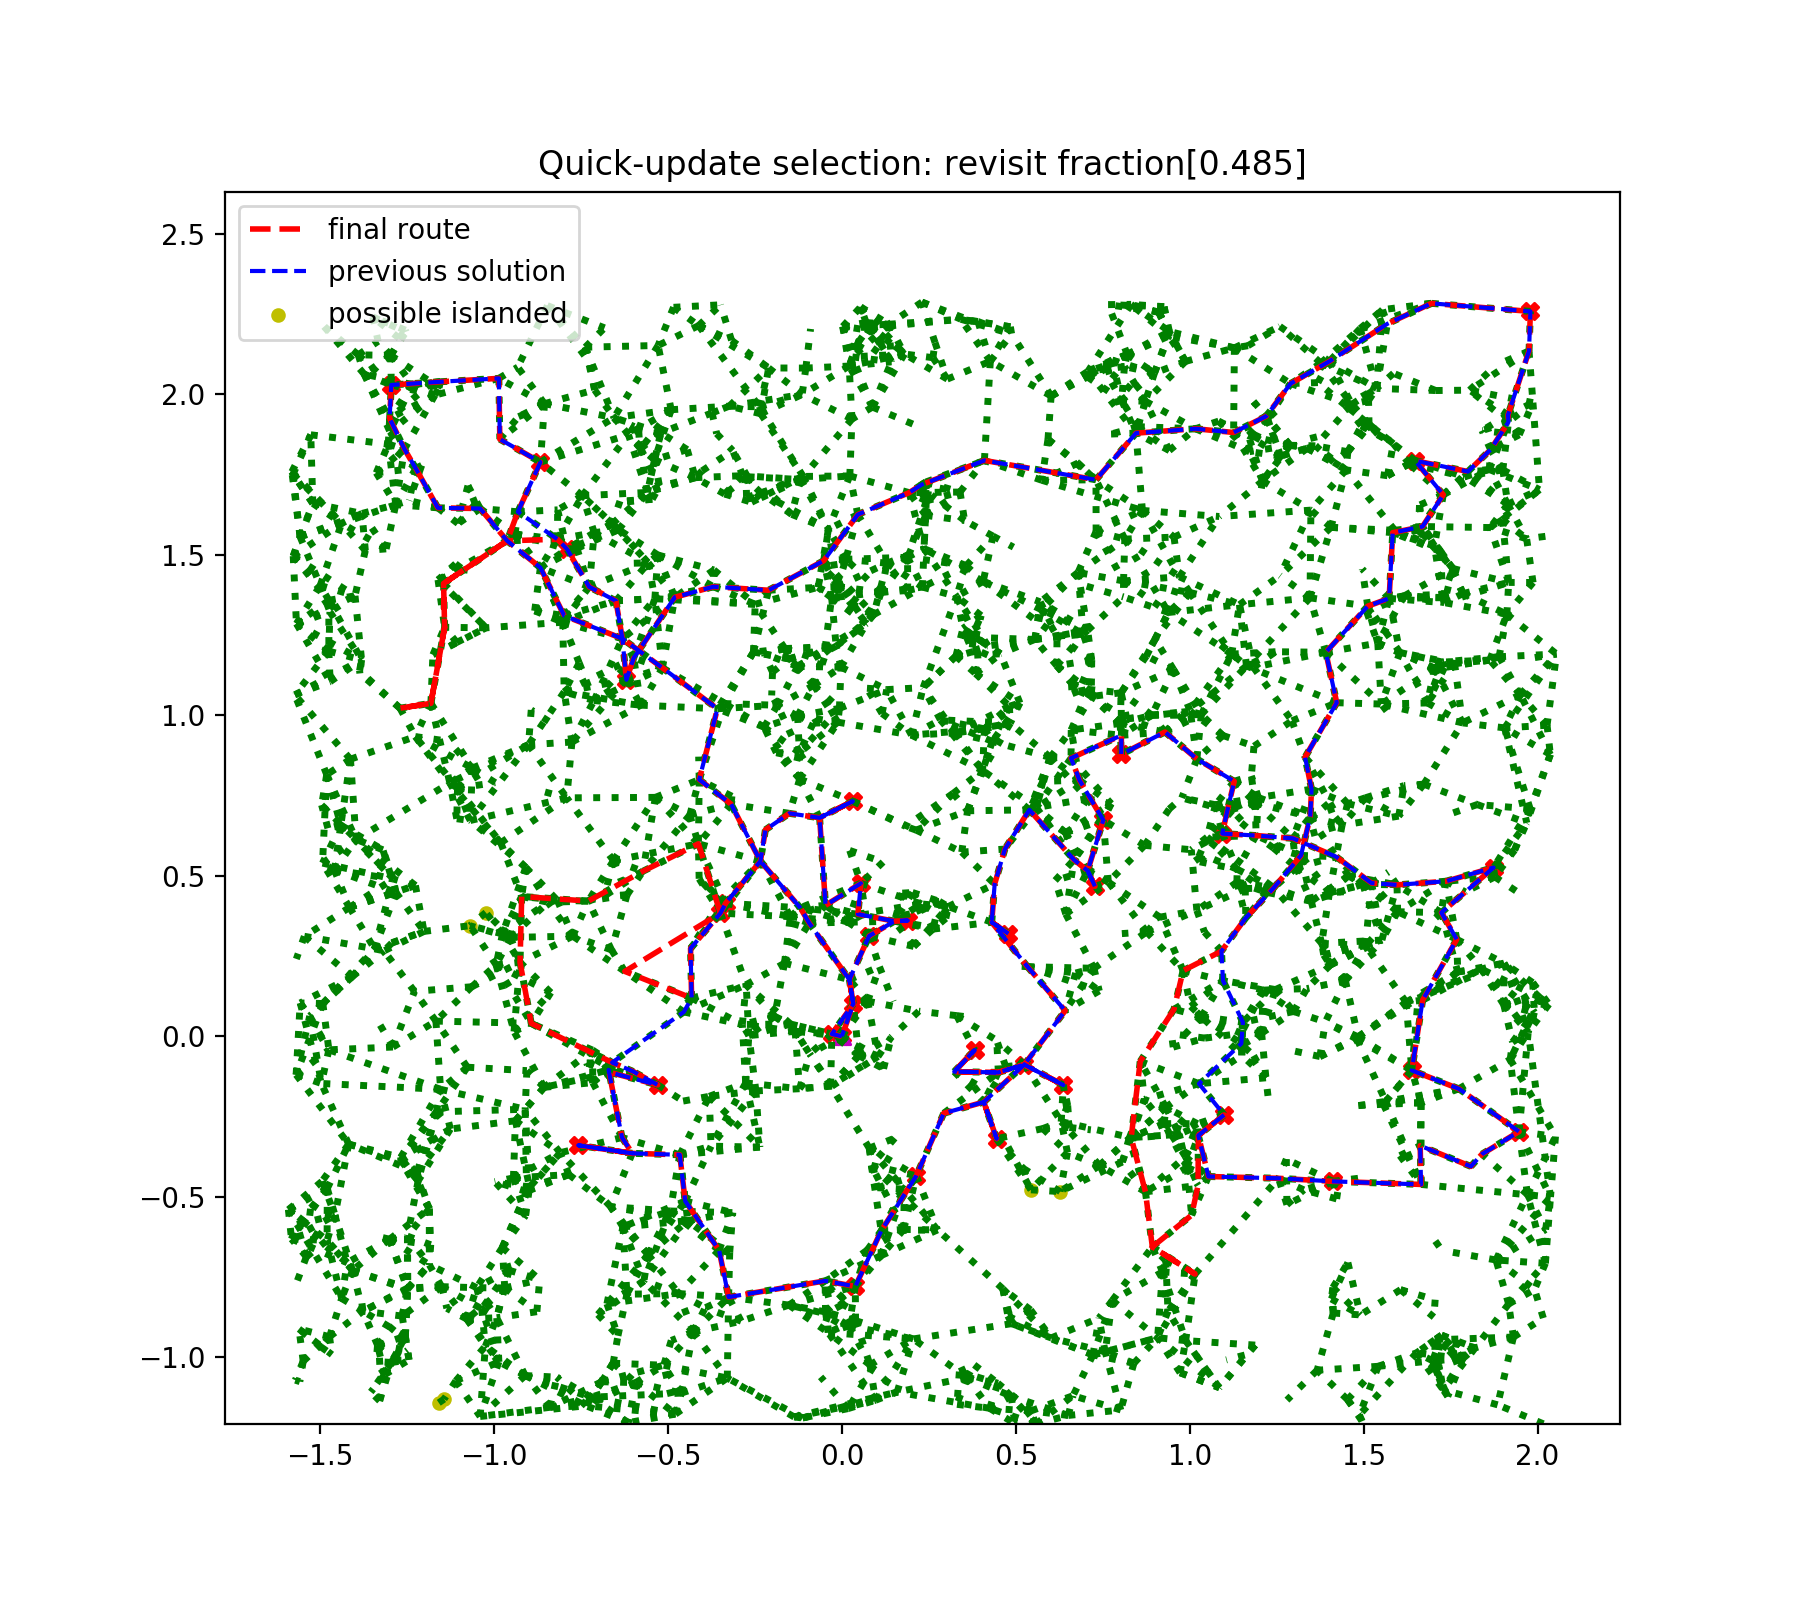

In [8]:
%matplotlib notebook


plot_mail_route(expanded_route_qu, stop_locations, mail_stop_indices, walkways, xrange, 
                alt_route=tsp_optimized_route_expd, alt_route_label='previous solution',
                islanded=islanded, alt_route_color='b',
                title=f'Quick-update selection: revisit fraction[{rand_revisit_frac:.3f}]')

<IPython.core.display.Javascript object>


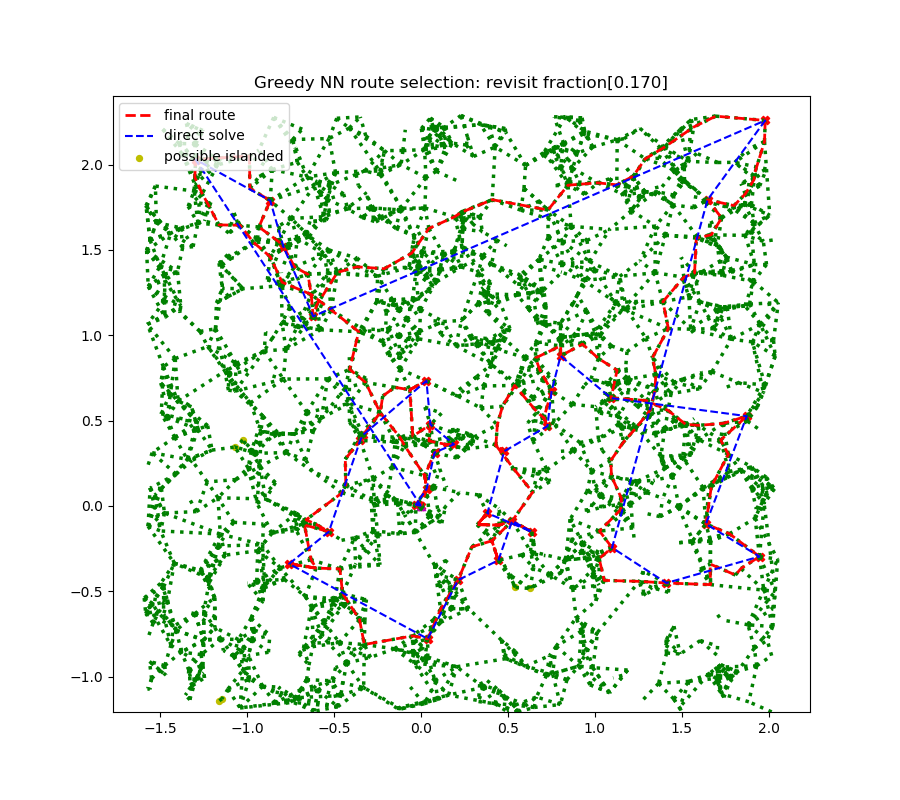

<IPython.core.display.Javascript object>


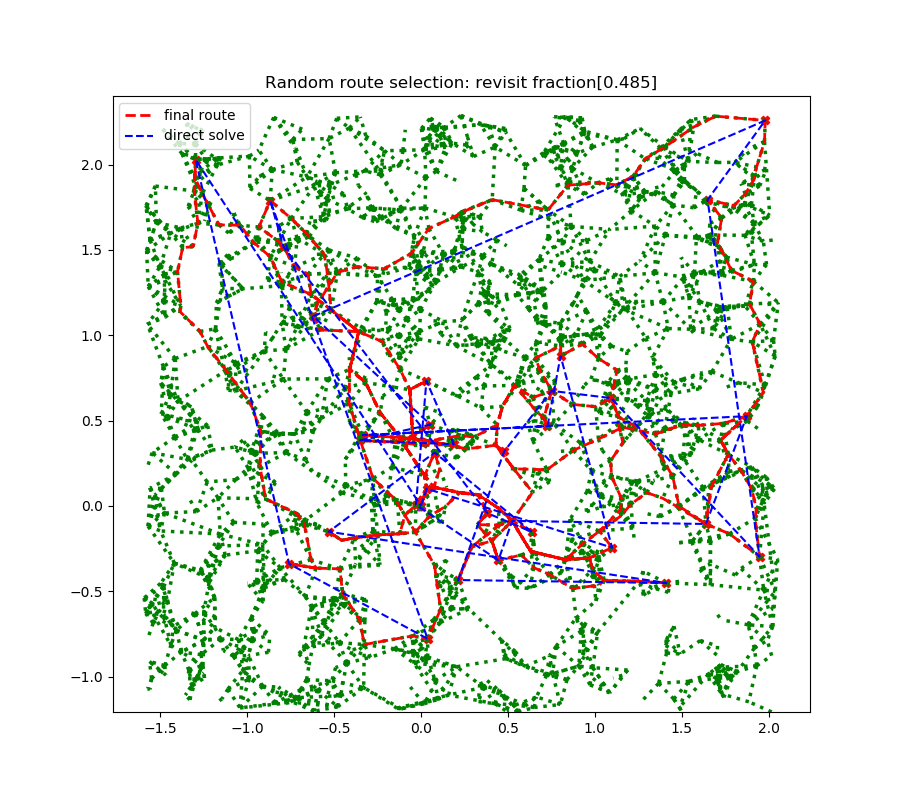

In [9]:
plot_mail_route(tsp_optimized_route_expd, stop_locations, mail_stop_indices, walkways, xrange, 
                alt_route=tsp_optimized_route, #plot_node_labels=True,
                islanded=islanded,
                title=f'Greedy NN route selection: revisit fraction[{opt_revisit_frac:.3f}]')
plot_mail_route(random_route_expd, stop_locations, mail_stop_indices, walkways, xrange, 
                alt_route=random_route, 
                title=f'Random route selection: revisit fraction[{rand_revisit_frac:.3f}]')